### Loading the data and performing an initial view

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
from scipy.stats import gamma
# there has been some incompatibilty between theano and numpy, if you encounter
# an error with the latest packages from anaconda, then the included
# package-list-txt should allow you to create a conda environment with compatible
# packages.

C:\Users\johne\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\johne\AppData\Local\Continuum\anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
medical = pd.read_csv('data/insurance2.csv')

In [3]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In [4]:
insurance = medical.charges[medical.insuranceclaim == 1]
no_insurance = medical.charges[medical.insuranceclaim == 0]
n_ins = len(insurance)
n_no_ins = len(no_insurance)

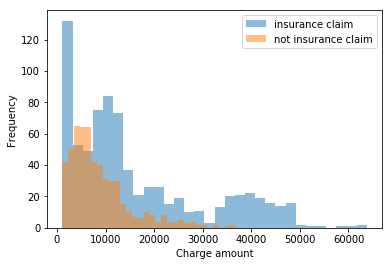

In [5]:
_ = plt.hist(insurance, bins=30, alpha=0.5, label='insurance claim')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='not insurance claim')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

### Initial parameter estimation

In [6]:
alpha_est = np.mean(no_insurance)**2 / np.var(no_insurance)
beta_est = np.var(no_insurance) / np.mean(no_insurance)
alpha_est, beta_est

(1.8759059725250857, 4702.486170152821)

### Initial simulation

In [7]:
seed(47)
no_ins_model_rvs = gamma(alpha_est, scale=beta_est).rvs(n_no_ins)

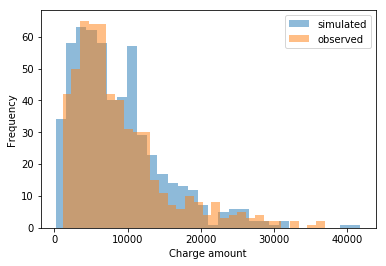

In [8]:
_ = plt.hist(no_ins_model_rvs, bins=30, alpha=0.5, label='simulated')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='observed')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

### Creating a PyMC3 model

In [9]:
# PyMC3 Gamma seems to use rate = 1/beta
rate_est = 1/beta_est
# Initial parameter estimates we'll use below
alpha_est, rate_est

(1.8759059725250857, 0.00021265346963636093)

__Q:__ You are now going to create your own PyMC3 model!
1. Use an [exponential](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Exponential) prior for alpha. Call this stochastic variable `alpha_`.
2. Similarly, use an exponential prior for the rate ([$1/\beta$](https://wiki.analytica.com/index.php?title=Gamma_distribution)) parameter in PyMC3's [Gamma](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Gamma). Call this stochastic variable `rate_` (but it will be supplied as `pm.Gamma`'s `beta` parameter). Hint: to set up a prior with an exponential distribution for $x$ where you have an initial estimate for $x$ of $x_0$, use a scale parameter of $1/x_0$.
5. Create your Gamma distribution with your `alpha_` and `rate_` stochastic variables and the observed data.
6. Perform 10000 draws.

__A:__

In [10]:
with pm.Model() as model: 
    alpha_ = pm.Exponential("alpha_", alpha_est)
    rate_  = pm.Exponential("rate_", rate_est)
    
    gamma_dist = pm.Gamma("gamma", alpha=alpha_, beta=rate_)

with model: 
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=500, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [gamma]
>Metropolis: [rate_]
>Metropolis: [alpha_]
Sampling 4 chains: 100%|████████████████████████████████████████████████████| 42000/42000 [00:12<00:00, 3329.97draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


If you get a warning about acceptance probability not matching the target, and that it's around 0.88 when it should be close to 0.8, don't worry. We encourage you to read up on this and see if you can adjust the parameters and/or arguments to pm.sample, but if your model runs without any additional warnings or errors then you should be doing great!

__Q:__ Explore your posteriors for $\alpha$ and $\beta$ (from the trace).
* Calculate the 95% credible interval for $\alpha$ and $\beta$.
* Plot your posterior values of $\alpha$ and $\beta$ (both line plots and histograms). 
* Mark your CIs on the histograms.
* Do they look okay? What would bad plots look like?

__A:__

In [11]:
from scipy.stats.mstats import mquantiles 

alpha_samples = trace["alpha_"][:, None]
rate_samples  = trace["rate_"][:, None]

alpha_qs = mquantiles(alpha_samples, [0.025, 0.975], axis=0)
beta_qs  = mquantiles(rate_samples, [0.025, 0.975], axis=0)

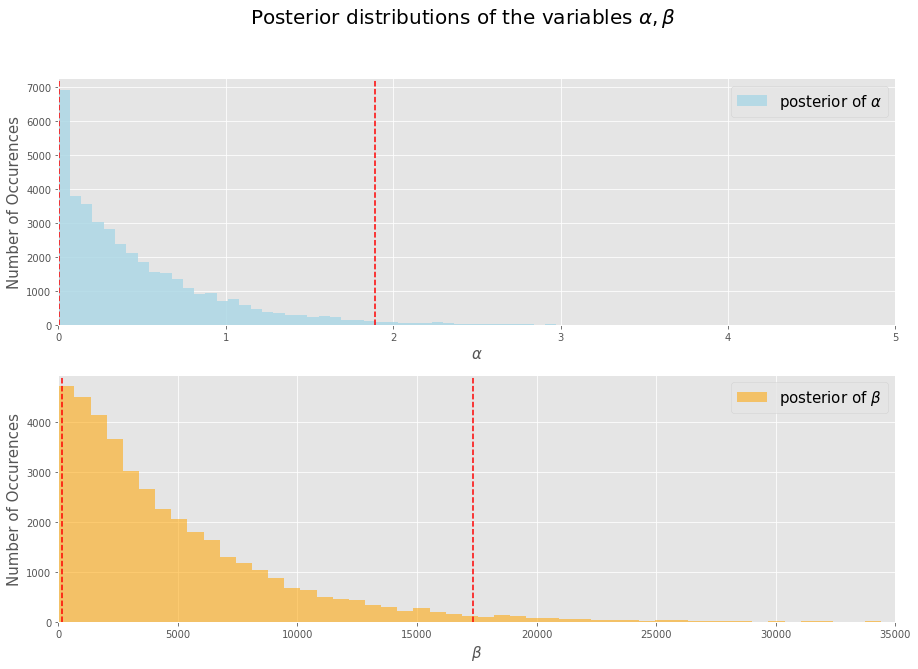

In [12]:
plt.style.use("ggplot")

fig, axes = plt.subplots(figsize=(15, 10), nrows=2)

fig.suptitle(r"Posterior distributions of the variables $\alpha, \beta$", fontsize=20)
axes[0].hist(alpha_samples, bins=75, histtype='stepfilled', alpha=0.85,
             label=r"posterior of $\alpha$", color='lightblue');
axes[0].set_xlabel(r"$\alpha$", size=15)
axes[0].set_ylabel("Number of Occurences", size=15)
axes[0].set_xlim(left=0, right=5)
axes[0].legend(prop={"size":15});
axes[0].axvline(alpha_qs[0], color='r', linestyle='--')
axes[0].axvline(alpha_qs[1], color='r', linestyle='--')


axes[1].hist(rate_samples, bins=75, histtype='stepfilled', alpha=0.55, 
             label=r"posterior of $\beta$", color='orange');
axes[1].set_xlim(left=0, right=35000)
axes[1].set_xlabel(r"$\beta$", size=15)
axes[1].set_ylabel("Number of Occurences", size=15)
axes[1].legend(prop={"size":15});
axes[1].axvline(beta_qs[0], color='r', linestyle='--')
axes[1].axvline(beta_qs[1], color='r', linestyle='--'); 

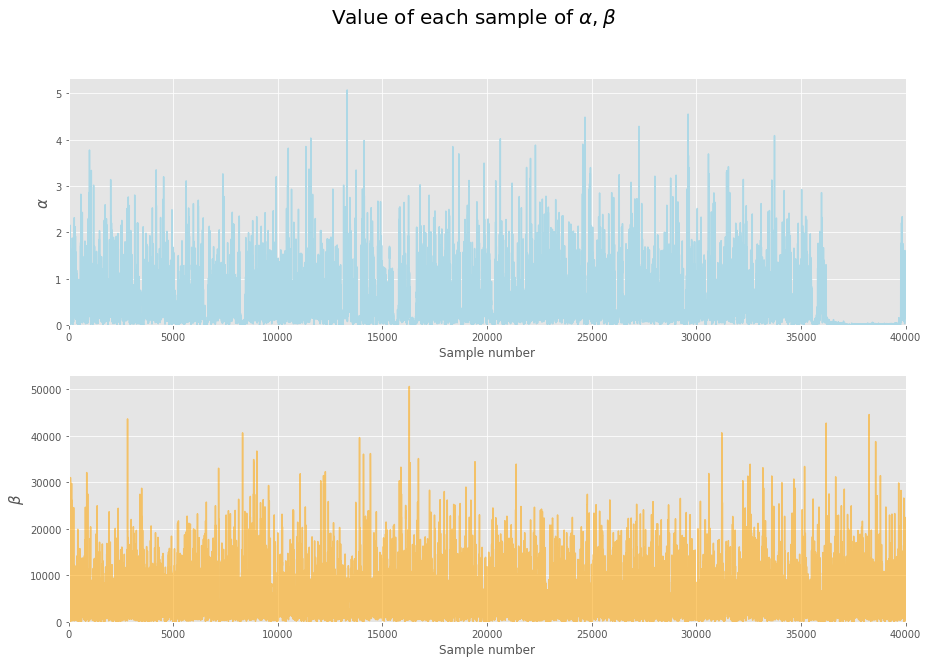

In [13]:
fig, axes = plt.subplots(figsize=(15, 10), nrows=2)

fig.suptitle(r'Value of each sample of $\alpha, \beta$', size=20)
axes[0].plot(alpha_samples, color="lightblue")
axes[0].set_xlim(left=0, right=40000)
axes[0].set_ylim(bottom=0)
axes[0].set_xlabel('Sample number', size=12)
axes[0].set_ylabel(r'$\alpha$', size=15)

axes[1].plot(rate_samples, color='orange', alpha=0.55)
axes[1].set_xlim(left=0, right=40000)
axes[1].set_ylim(bottom=0)
axes[1].set_xlabel('Sample number', size=12)
axes[1].set_ylabel(r'$\beta$', size=15);

Yes, these plots look okay. As expected, the posterior of the alpha and beta variables look like that of an exponential distribution. 

__Q:__ Play around with some of the built-in diagnostic plots for your model. We suggest at least checking out the traceplot for alpha and beta. How do they look?

__A:__

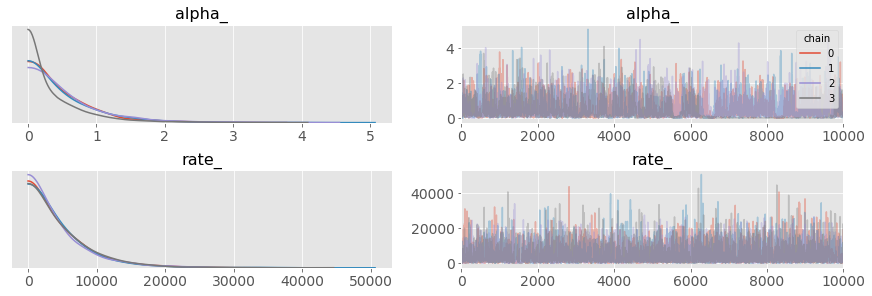

In [14]:
pm.plots.traceplot(trace, var_names=["alpha_", "rate_"], legend=True);

The traceplots match the histograms and lineplots plotted in the previous step. 

__Q:__ Take your best shot at a new simulated sequence of medical charges using scipy.stat's gamma distribution. Don't forget the difference between functions that take $\beta$ and functions that use $1/\beta$ for the scale parameter. Simulate a data set the same size as the number of observations in the data and overlay the two histograms (simulated and observed).

__A:__

(0, 66952.91700048279)

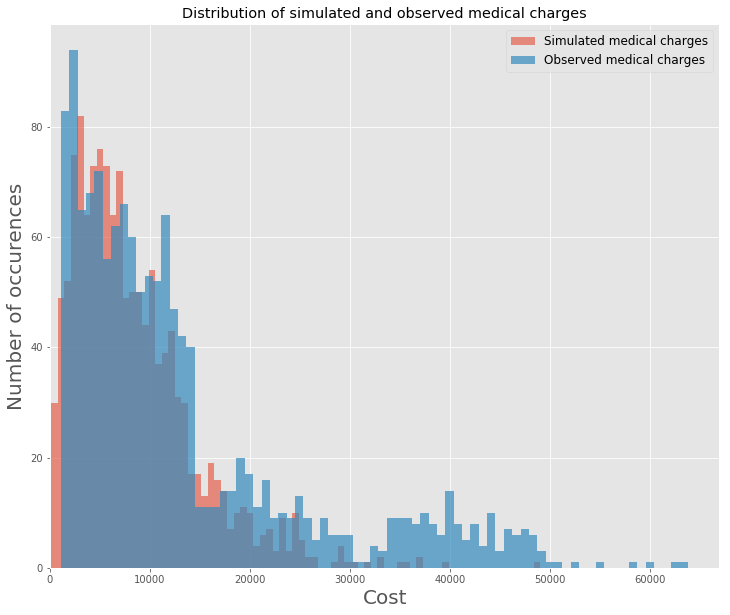

In [15]:
seed(47)

scipy_gamma_samples = gamma.rvs(a=alpha_est, loc=rate_est, size=len(medical.charges), scale=np.mean(medical.charges)/3) 
plt.figure(figsize=(12,10))
plt.hist(scipy_gamma_samples, bins=75, label=r'Simulated medical charges', alpha=0.6)
plt.hist(medical.charges, bins=75, label=r'Observed medical charges', alpha=0.7);
plt.legend(prop={"size":12})
plt.title("Distribution of simulated and observed medical charges")
plt.xlabel('Cost', size=20)
plt.ylabel('Number of occurences', size=20)
plt.xlim(left=0)